# Crop Classification

The project focus three stages of crop cylce, please follow below link for know about the stages. 

[Crop details](https://docs.google.com/drawings/d/1oyH4NqZqckdJBXbudCC-5BtxOSA5LPmg3pojAGm8RP4/edit?usp=sharing)

Project focuses on 7 classes of crops which is divided into 4 different categories depending upon the respective crop cycle.


| crop      | crop_class |
| ----------- | ----------- |
| barley_w      | 1       |
| wheat_w   | 2        |
| rapeseed_w      | 3       |
| rye_w   | 4        |
| barley_s      | 5       |
| wheat_s   | 6        |
| oats_s   | 7       |



## Know the crop data

#### Import

In [1]:
import pandas as pd
import numpy as np
import rioxarray
import os
import geopandas as gpd
import rasterio
import fiona

import rasterio.mask
import sys
from pathlib import Path

from tqdm import tqdm

from data_op import shapefile
from config import settings as st

In [2]:
crop_classes = pd.read_excel(os.path.join(st.data_directory,'crop_code/croptable_2020.xlsx'))

In [3]:
crop_classes

,Crop_nr,Name
0,1,Spring barley
1,2,Spring wheat
2,3,Spring oats
3,4,Mix of spring sown cereals
4,5,Maize for maturity
...,...,...
321,711,Green grain of winter triticale
322,900,Other crops
323,903,Light and open areas in wood
324,905,Other use on areas with schemes


In [9]:
crop_classes_list = np.unique(crop_classes.Crop_nr)
print(len(crop_classes_list))

326


Distinct crop classes and names for 7 crops, divided into 4 categories depending upon the respective crop cycle, 

**Categories**

| Index      | Months |
| ----------- | ----------- |
| 1      |  Jan-Mar      |
| 2   | Apr-Jun        |
| 3      | Jul-Sep       |
| 4   | Oct-Nov        |

**Category wise crop classes**

</br>
</br>

**1. Jan-Mar**

| crop      | Crop_nr |   cycle_stage     |
| ----------- | ----------- | ----------- |
|  barley_w     |   706     | mid |
| wheat_w   | 707       | mid |
| rye_w      | 709,710      | mid |

</br>
</br>

**2. Apr-Jun**

| crop      | Crop_nr |   cycle_stage      |
| ----------- | ----------- | ----------- |
|  barley_w     |   706     | mid |
| wheat_w   | 707       | mid |
| rye_w      | 709,710      | mid |
| barley_s   | 01,701      | planting and mid |
| wheat_s      | 02,06,702     | planting and mid  |
| oats_s      | 03,703    | planting and mid  |

</br>
</br>


**3. Jul-Sep**

| crop      | Crop_nr |   cycle_stage      |
| ----------- | ----------- | ----------- |
|  barley_w     |   706,220     | mid and harvest |
| wheat_w   | 707,221       | mid and harvest|
| rye_w      | 222     | harvest |
| barley_s   | 701,210      | mid and harvest |
| wheat_s      | 702,211     | mid and harvest |
| oats_s      | 703,212    | mid and harvest  |

</br>
</br>


**4. Oct-Dec**

| crop      | Crop_nr |   cycle_stage      |
| ----------- | ----------- | ----------- |
|  barley_w     | 10    | planting|
| wheat_w   | 11,13      | planting|
| rapeseed_w      | 22     | planting |
| rye_w      | 14,15     | planting |
| barley_s   | 210      | harvest |
| wheat_s      | 211     | harvest |

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

Summmer and Winter crop categorisation

| Season      | crop |
| ----------- | ----------- |
| Winter      | barley_w, wheat_w, rapeseed_w, rye_w       |
| Summer/Spring   | barley_s,wheat_s,oats_s        |

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

**1. Jan-Mar**

| crop      | Crop_nr |   cycle_stage     |
| ----------- | ----------- | ----------- |
|  barley_w     |   10     | mid |
| wheat_w   | 11,13       | mid |
| rye_w      | 14,15      | mid |
| rapeseed_w      | 22     | mid |

**2. Apr-Jun**

| crop      | Crop_nr |   cycle_stage     |
| ----------- | ----------- | ----------- |
|  barley_w     |   10     | mid |
| wheat_w   | 11,13       | mid |
| rye_w      | 14,15      | mid |
| rapeseed_w      | 22     | mid |
| barley_s   | 01      | planting and mid  |
| wheat_s      | 02,06     | planting and mid |
| oats_s      | 03   | planting and mid |

**3. Jul-Sep**

| crop      | Crop_nr |   cycle_stage     |
| ----------- | ----------- | ----------- |
|  barley_w     |   10     | mid and harvest |
| wheat_w   | 11,13       | mid and harvesst|
| rye_w      | 14,15      | harvest |
| rapeseed_w      | 22     | harvest |
| barley_s   | 01     | mid and harvest |
| wheat_s      | 02,06     | mid and harvest |
| oats_s      | 03   | mid and harvest  |

**4. Oct-Dec**

| crop      | Crop_nr |   cycle_stage     |
| ----------- | ----------- | ----------- |
|  barley_w     |   10     | planting |
| wheat_w   | 11,13       | planting|
| rye_w      | 14,15      | planting |
| rapeseed_w      | 22     | planting |
| barley_s   | 01     |  harvest |
| wheat_s      | 02,06     | harvest |






## Prepare Dataset



In [2]:
# Create 4 shapefiles from 4 categorise 
path_raw = 'Raw_shape_files/Raw_downloaded_files'
shape_ex = shapefile.Shape_Extractor(shape_file = os.path.join(st.data_directory,path_raw,'Denmark_shape_2020/Marker_2020.shp'))
denmark_veg = shape_ex.import_shape()

#rename column 
denmark_veg.reset_index(drop=True, inplace=True)
denmark_veg = denmark_veg.rename(columns = {'Afgkode':'code'},errors='raise')
columns_to_be_remove= ['Marknr', 'IMK_areal', 'Journalnr', 'CVR', 'Afgroede', 'GB','Markblok', 'GBanmeldt']
denmark_veg = shape_ex.filter_shape_data(df = denmark_veg,column_names = columns_to_be_remove)

In [7]:
# category 1 jan-march
classes_for_cat_1 = {
    'barley_w': [706],
    'wheat_w': [707],
    'rye_w': [709,710]
    }
denmark_veg_cat_1 = shape_ex.prepare_labels(df = denmark_veg,class_dictionary = classes_for_cat_1,id_col = 'code',label_name='classes')

<AxesSubplot:>

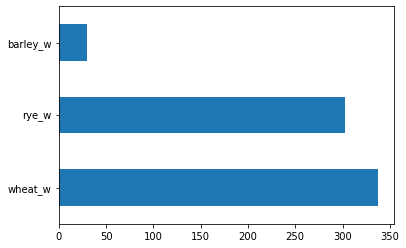

In [8]:
denmark_veg_cat_1['r_classes'].value_counts().plot(kind='barh')

## Satellite Imagery Download

In [4]:
import geemap
import ee
import IPython

In [9]:

ee.Initialize()
Map = geemap.Map(center=[56.2639,9.5018], zoom=7)
Map

Map(center=[56.2639, 9.5018], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton…

In [10]:
denmark_geometry =ee.Geometry.Polygon(
        [[[8.06, 57.74],
          [10.62,57.74],
          [11.21, 57.31],
          [11.67, 56.74],
          [12.62,56.03],
          [12.64,55.81],
          [12.78,55.67],
          [12.79,55.64],
          [12.85,55.56],
          [12.57,54.94],
          [11.96, 54.55],
          [11.46, 54.60],
          [10.67,54.70],
          [9.937345,54.848469],
          [9.692023,54.828515],
          [9.636622,54.860250],
          [9.608859,54.890788],
          [9.485931,54.839107],
          [9.422113,54.830018],
          [9.343855,54.800103],
          [9.330371,54.804208],
          [9.329360,54.805617],
          [9.293550,54.808889],
          [9.292091,54.806168],
          [9.295584,54.803154],
          [9.250266,54.809606],
          [9.031632,54.876914],
          [8.778732,54.891528],
          [8.60156,54.910120],
          [8.50,55.05],
          [8.45,55.09],
          [8.06, 55.55]]], None, False);

In [24]:
# cloud precentage 2 for jan-sep and cloud percentage 10 for oct-dec
dataset = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(denmark_geometry) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',8)) \
    .filterDate('2020-10-01', '2020-12-31') \
    .select(['B2', 'B3', 'B4']);
mosaic = dataset.mosaic().clip(denmark_geometry);

sentinel_vis = {
    'bands': ['B4', 'B3', 'B2'],
    'min':0, 
    'max':3000
    
}




In [25]:

Map.addLayer(mosaic, sentinel_vis , 'mosaic');
Map.centerObject(denmark_geometry);
image,request = mosaic._apply_visualization(sentinel_vis)


In [26]:
task_jul = ee.batch.Export.image.toDrive(image=image,  # an ee.Image object.
                                     region=denmark_geometry,  # an ee.Geometry object.
                                     description='denmark_export',
                                     folder='Fieldsegmentation_Oct_Dec',
                                     fileNamePrefix='denmark',
                                     scale=10,
                                     crs='EPSG:4326',
                                     maxPixels = 1e12)
task_jul.start()